## Loading basic data

In [1]:
import pandas as pd
import numpy as np
import time
import re
from IPython.display import display
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use("seaborn-v0_8")

In [2]:
df = pd.read_csv("MC1/Lekagul Sensor Data.csv")

# Parse timestamps
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

# Parse gate type from gate ID
df["gate-type"] = df["gate-name"].str.extract(re.compile(r"^([a-zA-Z\-]+)[0-9]+$"))[0].fillna(df["gate-name"])
print("Gate types:", ', '.join(df["gate-type"].unique()))

# Parse whether the vehicle is an official preserve vehicle
df["is-preserve-vehicle"] = df["car-type"].str.endswith("P")
print("\nEvents by park pass status:")
display(df.reset_index().groupby("is-preserve-vehicle").agg({ "index": "count", "car-id": "nunique" }).rename(columns={ "index": "sensor readings", "car-id": "unique vehicles" }))
print("\nVehicles with most sensor readings:")
display(df.groupby(["car-id", "car-type", "is-preserve-vehicle"]).agg({ "Timestamp": "count" }).rename(columns={ "Timestamp": "count" }).sort_values("count", ascending=False).head(10))

Gate types: entrance, general-gate, ranger-stop, camping, ranger-base, gate

Events by park pass status:


,sensor readings,unique vehicles
is-preserve-vehicle,,
False,147922,17710
True,23555,998



Vehicles with most sensor readings:


,,,count
car-id,car-type,is-preserve-vehicle,
20154519024544-322,2,False,281
20154112014114-381,1,False,98
20155705025759-63,1,False,70
20164106064104-865,2P,True,49
20153326053354-839,2P,True,49
20160520070545-547,2P,True,49
20161608111648-744,2P,True,49
20152730112706-517,2P,True,49
20151110011101-322,2P,True,49


## Identifying separate “trips”
Vehicles can enter/exit the park on multiple occasions; for convenience of analysis we should mark
each of those occasions as a separate “trip”

In [3]:
# Assign a trip id to each unique visit to the park (one car can make multiple visits)
df["trip-id"] = pd.Series(index=df.index, dtype=np.int32)

# this is super inefficient
trip_id = -1
in_park = False
prev_car_id = None
for idx, row in df.sort_values(["car-id", "Timestamp"]).iterrows():
    # New trip each time we see a new car
    if prev_car_id != row["car-id"]:
        in_park = row["gate-type"] == "entrance"
        prev_car_id = row["car-id"]
        trip_id += 1
    # New trip each time we enter the park
    elif row["gate-type"] == "entrance":
        in_park = not in_park
        if in_park: trip_id += 1

    df.loc[idx, "trip-id"] = trip_id

df = df.astype({ "trip-id": np.int32 })

print(df["trip-id"].nunique(), "unique “trips” among", df["car-id"].nunique(), "unique vehicles")
print("Vehicles with the most separate trips:")
display(df.groupby(["car-id", "car-type", "is-preserve-vehicle"]).agg({ "trip-id": "nunique" }).rename(columns={ "trip-id": "# trips" }).sort_values("# trips", ascending=False).head(10))
print("Example trip:")
display(df[df["trip-id"] == 0])

18745 unique “trips” among 18708 unique vehicles
Vehicles with the most separate trips:


,,,# trips
car-id,car-type,is-preserve-vehicle,
20154519024544-322,2,False,16
20154112014114-381,1,False,7
20162904122951-717,1,False,6
20153712013720-181,3,False,4
20162027042012-940,1,False,3
20153427103455-30,4,False,2
20150204100226-134,4,False,2
20161008061012-639,4,False,2
20150322080300-861,4,False,2


Example trip:


,Timestamp,car-id,car-type,gate-name,gate-type,is-preserve-vehicle,trip-id
36467,2015-07-01 13:00:09,20150001010009-284,3,entrance3,entrance,False,0
36511,2015-07-01 13:20:53,20150001010009-284,3,general-gate1,general-gate,False,0
36516,2015-07-01 13:23:32,20150001010009-284,3,ranger-stop2,ranger-stop,False,0
36524,2015-07-01 13:26:36,20150001010009-284,3,ranger-stop0,ranger-stop,False,0
36528,2015-07-01 13:29:51,20150001010009-284,3,general-gate2,general-gate,False,0
36543,2015-07-01 13:41:28,20150001010009-284,3,general-gate5,general-gate,False,0
36561,2015-07-01 13:51:51,20150001010009-284,3,camping6,camping,False,0
37951,2015-07-02 19:28:13,20150001010009-284,3,camping6,camping,False,0
37962,2015-07-02 19:47:56,20150001010009-284,3,entrance2,entrance,False,0


## Build adjacency graph

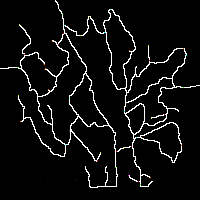

Roadway image: (200, 200, 3)


In [4]:
from PIL import Image
roadways_map = Image.open("MC1/Lekagul Roadways.bmp").convert("RGB")
display(roadways_map)

roadways_np = np.array(roadways_map) / 255
print("Roadway image:", roadways_np.shape)

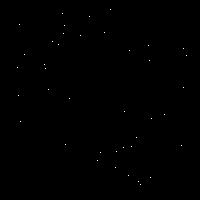

Found 40 color “sensor” pixels on map


In [5]:
# Sensors are whre there are color pixels
is_sensor = np.max(roadways_np, axis=2) - np.min(roadways_np, axis=2) > 0.1 # find strong(ish)-ly non-grayscale pixels
display(Image.fromarray((is_sensor * 255).astype(np.uint8)))

sensor_coords = np.argwhere(is_sensor)
print(f"Found {sensor_coords.shape[0]} color “sensor” pixels on map")

Load and sanity-check the unique “sensor names” that we pre-assigned to each coordinate pair on the map (from sensors-identified.txt):

In [6]:
sensors = pd.read_csv("sensors.csv")
sensor_ids = { c: i for c, i in zip(zip(sensors.y, sensors.x), sensors.id) }

def classify_sensor(pixel_color):
    if pixel_color[0] < 0.33 and pixel_color[1] > 0.95 and pixel_color[2] < 0.05: return "entrance" # green
    if pixel_color[0] < 0.05 and pixel_color[1] > 0.95 and pixel_color[2] > 0.95: return "general-gate" # blue / cyan
    if pixel_color[0] > 0.95 and pixel_color[1] < 0.05 and pixel_color[2] < 0.05: return "gate" # red
    if pixel_color[0] > 0.95 and pixel_color[1] > 0.8 and pixel_color[2] < 0.05: return "ranger-stop" # yellow
    if pixel_color[0] > 0.95 and pixel_color[1] > 0.4 and pixel_color[1] < 0.5 and pixel_color[2] < 0.05: return "camping" # orange
    if pixel_color[0] > 0.95 and pixel_color[1] < 0.05 and pixel_color[2] > 0.80: return "ranger-base" # purple

for c in sensor_coords:
    recorded_id = sensor_ids[tuple(c)]
    classification = classify_sensor(roadways_np[tuple(c)])
    if not recorded_id.startswith(classification):
        raise ValueError(f"Mismatch at {c}: {recorded_id} does not start with {classification}")

Identify adjacency between colored “sensor” pixels on the map:

[example exploration] Adjacency map from (9, 110):


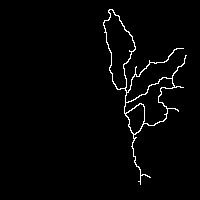

Built adjacency map from each of 40 sensors (in 0.12s)


In [7]:
def find_connected_sensors(start_pos, debug = False):
    start_pos = tuple(start_pos)
    visited = np.zeros(roadways_np.shape[:2], dtype=bool)
    stack = [start_pos]
    found = []
    while len(stack) > 0:
        idx = stack.pop()
        if visited[idx]: continue # Don’t re-explore visited pixels
        visited[idx] = True # Mark we‘ve been here

        # Record when we find sensor pixels, and then don’t explore further, because further sensor
        # pixels aren’t “adjacent” to this pixel (because someone would have had to go through this
        # sensor first)
        if is_sensor[idx] and idx != start_pos:
            found.append(idx)
            continue

        i, j = idx
        for newidx in [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]:
            # Don’t go out of bounds
            if newidx[0] < 0 or newidx[0] >= roadways_np.shape[0]: continue
            if newidx[1] < 0 or newidx[1] >= roadways_np.shape[1]: continue
            # Don’t revisit pixels
            if visited[newidx]: continue
            # Don’t visit black pixels
            if np.max(roadways_np[newidx]) < 0.5: continue
            # If those checks passed, schedule a visit
            stack.append(newidx)

    if debug:
        print(f"Adjacency map from {start_pos}:")
        display(Image.fromarray((visited * 255).astype(np.uint8)))
    return found


# Example output
print("[example exploration] ", end="")
find_connected_sensors(sensor_coords[0], debug=True)

a = time.time()
sensor_adjacency = {
    sensor_ids[tuple(c1)]: [sensor_ids[c2] for c2 in find_connected_sensors(c1)]
    for c1 in sensor_coords
}
print(f"Built adjacency map from each of {len(sensor_coords)} sensors (in {time.time() - a:.2f}s)")

Write the adjacency map to a file for future use

In [8]:
sensors_graph_df = sensors.copy()
sensors_graph_df["adj"] = sensors_graph_df["id"].map(sensor_adjacency).str.join(" ")
# sensors_graph_df.to_csv("../src/public/sensors-graph.csv", index=False)

Identifying “off-roading”:

In [9]:
discontinuities = 0
for trip_id, trip_df in df.groupby("trip-id"):
    if discontinuities > 10:
        print("Warning: reached 10 discontinuous trips; not reporting any more")
        break
    for i in range(1, len(trip_df)):
        prev = trip_df.iloc[i-1]
        cur = trip_df.iloc[i]
        if (cur["gate-name"] != prev["gate-name"]) and (cur["gate-name"] not in sensor_adjacency[prev["gate-name"]]):
            print(f"Trip {trip_id} has a discontinuity between {prev['gate-name']} and {cur['gate-name']}")
            display(trip_df)
            discontinuities += 1
            break

Trip 7245 has a discontinuity between entrance1 and ranger-stop1


,Timestamp,car-id,car-type,gate-name,gate-type,is-preserve-vehicle,trip-id
47953,2015-07-10 10:28:03,20152810102803-808,1,entrance1,entrance,False,7245
47972,2015-07-10 10:35:47,20152810102803-808,1,ranger-stop1,ranger-stop,False,7245
48089,2015-07-10 12:00:49,20152810102803-808,1,ranger-stop1,ranger-stop,False,7245
48105,2015-07-10 12:08:29,20152810102803-808,1,entrance1,entrance,False,7245


Trip 7246 has a discontinuity between entrance1 and ranger-stop1


,Timestamp,car-id,car-type,gate-name,gate-type,is-preserve-vehicle,trip-id
47954,2015-07-10 10:28:19,20152810102819-458,1,entrance1,entrance,False,7246
47973,2015-07-10 10:36:00,20152810102819-458,1,ranger-stop1,ranger-stop,False,7246
48328,2015-07-10 13:56:02,20152810102819-458,1,ranger-stop1,ranger-stop,False,7246
48341,2015-07-10 14:03:41,20152810102819-458,1,entrance1,entrance,False,7246


Trip 7247 has a discontinuity between entrance1 and ranger-stop1


,Timestamp,car-id,car-type,gate-name,gate-type,is-preserve-vehicle,trip-id
47955,2015-07-10 10:28:28,20152810102828-459,1,entrance1,entrance,False,7247
47975,2015-07-10 10:36:22,20152810102828-459,1,ranger-stop1,ranger-stop,False,7247
48573,2015-07-10 16:21:24,20152810102828-459,1,ranger-stop1,ranger-stop,False,7247
48579,2015-07-10 16:29:15,20152810102828-459,1,entrance1,entrance,False,7247


Trip 7513 has a discontinuity between entrance1 and ranger-stop1


,Timestamp,car-id,car-type,gate-name,gate-type,is-preserve-vehicle,trip-id
47956,2015-07-10 10:29:28,20152910102928-970,1,entrance1,entrance,False,7513
47976,2015-07-10 10:36:35,20152910102928-970,1,ranger-stop1,ranger-stop,False,7513
48528,2015-07-10 15:50:37,20152910102928-970,1,ranger-stop1,ranger-stop,False,7513
48537,2015-07-10 15:57:40,20152910102928-970,1,entrance1,entrance,False,7513


Trip 7516 has a discontinuity between entrance1 and ranger-stop1


,Timestamp,car-id,car-type,gate-name,gate-type,is-preserve-vehicle,trip-id
47961,2015-07-10 10:29:59,20152910102959-782,1,entrance1,entrance,False,7516
47981,2015-07-10 10:37:57,20152910102959-782,1,ranger-stop1,ranger-stop,False,7516
48398,2015-07-10 14:36:59,20152910102959-782,1,ranger-stop1,ranger-stop,False,7516
48412,2015-07-10 14:44:54,20152910102959-782,1,entrance1,entrance,False,7516


Trip 7771 has a discontinuity between entrance1 and ranger-stop1


,Timestamp,car-id,car-type,gate-name,gate-type,is-preserve-vehicle,trip-id
47962,2015-07-10 10:30:17,20153010103017-871,1,entrance1,entrance,False,7771
47979,2015-07-10 10:37:31,20153010103017-871,1,ranger-stop1,ranger-stop,False,7771
48360,2015-07-10 14:14:33,20153010103017-871,1,ranger-stop1,ranger-stop,False,7771
48372,2015-07-10 14:21:44,20153010103017-871,1,entrance1,entrance,False,7771


### Sensor readings by hour of day by car type

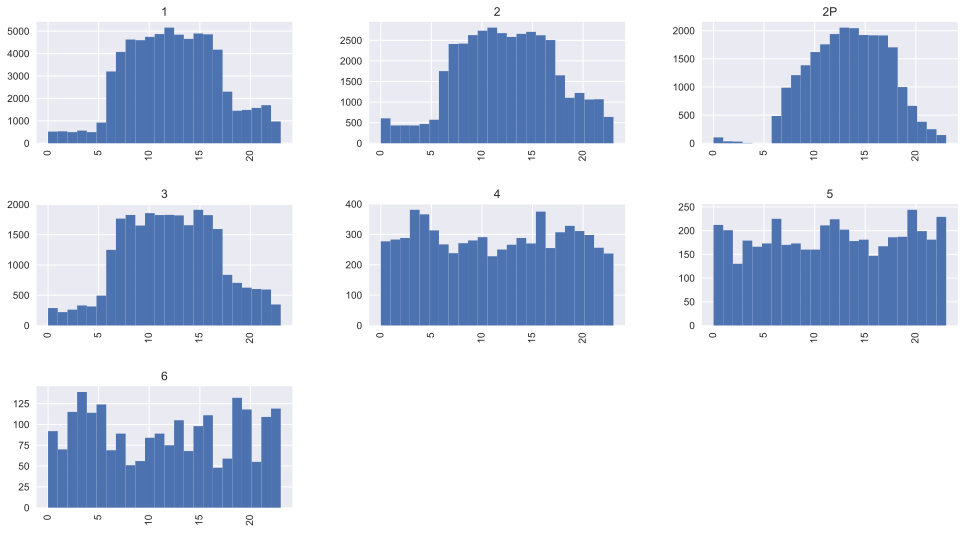

In [10]:
df["Timestamp"].dt.hour.hist(by=df["car-type"], bins=24, figsize=(16, 9));

### *Entering the park* by hour of day by car type

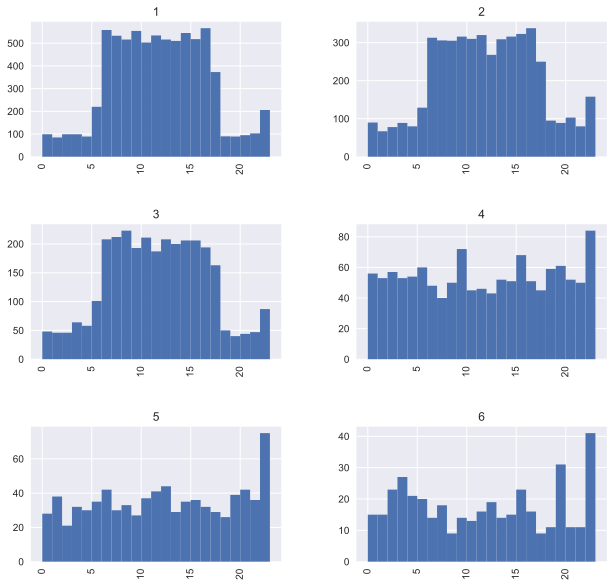

In [11]:
trip_entrances = df.groupby("trip-id").first()
trip_entrances.drop(index=trip_entrances[trip_entrances["gate-type"] != "entrance"].index, inplace=True)
trip_entrances["Timestamp"].dt.hour.hist(by=trip_entrances["car-type"], bins=range(24), figsize=(10, 10));

### *Exiting the park* by hour of day by car type

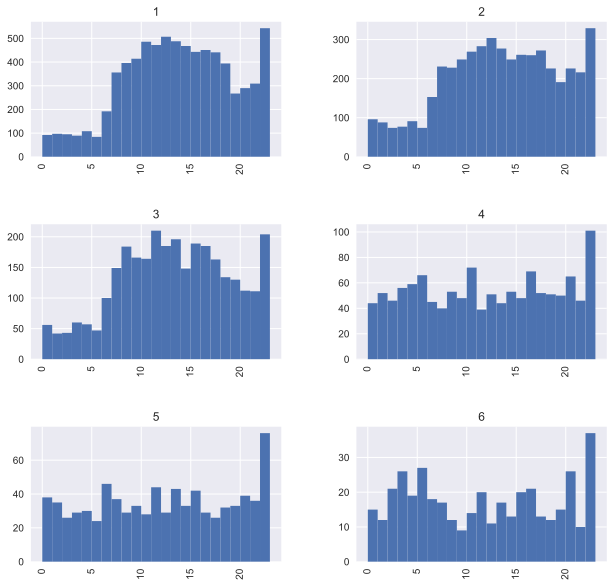

In [12]:
trip_exits = df.groupby("trip-id").last()
trip_exits.drop(index=trip_exits[trip_exits["gate-type"] != "entrance"].index, inplace=True)
trip_exits["Timestamp"].dt.hour.hist(by=trip_exits["car-type"], bins=range(24), figsize=(10, 10));